In [1]:
import numpy as np
import os
from cellpose import utils, io, models
from cellpose import plot
import matplotlib.pyplot as plt
from PIL import Image
from scipy.optimize import curve_fit

In [4]:
def ctc_2_CNet(path_X,suff_X,path_Y,suff_Y,start_ind,prompt='hela_ctc',alt=0,save_dir='/home/mo/Desktop/IWR/Cell_GT_Proj/CNet_cells/',test=False):
    
    data=[]
    l_ind=start_ind
    for i in range(350):
        
        try:
            output_path_Y_c = save_dir+'source/'+str(start_ind+i)+'contr.png'
            
            path_r_X=path_X+suff_X+'{:03d}'.format(i)+'.tif'
            path_r_Y=path_Y+suff_Y+'{:03d}'.format(i)+'_cp_masks.png'
            # read the tif file
            #print('p',path_r)
            #try:
            #img_r_X = tiff.imread(path_r_X)
            #img_r_Y = tiff.imread(path_r_Y)
            img_r_X = imread(path_r_X)
            img_r_Y = imread(path_r_Y)


            max_X=np.max(img_r_X)
            img_r_X = (img_r_X/max_X)*255
            max_y=np.max(img_r_Y)
            img_r_Y = (img_r_Y/max_y)*255
            
            
            if prompt=='fluo_ctc, cell, microscopy image, grayscale':
                
                start_x = np.random.randint(0, img_r_X.shape[1] - 512)
                end_x = start_x + 512
                start_y = np.random.randint(0, img_r_X.shape[0] - 512)
                end_y = start_y + 512

                # Crop the random region from img_r_X
                img_r_X = img_r_X[start_y:end_y, start_x:end_x]

                # Crop the random region from img_r_Y
                img_r_Y = img_r_Y[start_y:end_y, start_x:end_x]
            


            u_val = source2CNet(img_r_Y,alt,prompt,first=True)

     
            img_r_X,img_r_Y=augment_images(img_r_X, img_r_Y,alt=alt)


            #if alt==1:
            #    cv2.imwrite(output_path_Y_c, img_r_Y)



            resized_X = cv2.resize(img_r_X, (512, 512))
            resized_Y = cv2.resize(img_r_Y, (512, 512))

            resized_Y_s = source2CNet(resized_Y,alt,prompt,u_v=u_val,test=test)

            # Specify the output file path
            if test:
                save_dir='/home/mo/Desktop/IWR/Cell_GT_Proj/CNet_cells_rd/'
                
            
            
            output_path_X = save_dir+'target/'+str(start_ind+i)+'.png'
            output_path_Y = save_dir+'source/'+str(start_ind+i)+'.png'
            #output_path_Y_c = save_dir+'source/'+str(start_ind+i)+'contr.png'



            # Save the resized image as PNG
            cv2.imwrite(output_path_X, resized_X)
            cv2.imwrite(output_path_Y, resized_Y_s)
            

            entry = {
            "source": "source/" + str(start_ind+i) + ".png",
            "target": "target/" + str(start_ind+i) + ".png",
            "prompt": prompt
            }

            # Append the entry to the data list
            data.append(entry)

            l_ind=l_ind+1

                # Write the data list as JSON to a file



        except Exception as e:
            if not str(e).startswith("[Errno 2]"):
                traceback.print_exc()
            #print("An error occurred:", str(e))

        
        
    output_path = save_dir+"/prompt.json"    
    existing_data = []



    # Read existing data from the JSON file, if it exists
    try:
        with open(output_path, "r") as infile:
            for line in infile:
                line = line.strip()  # Remove leading/trailing whitespaces
                if line:
                    data_j = json.loads(line)
                    existing_data.append(data_j)
    except FileNotFoundError:
        pass

    #print('!!!!!!ex',existing_data)
    #print('!!!!!!dat',data)
    # Append new entries to the existing data
    existing_data=existing_data+data
    #print('!!!!!!ex2',existing_data)

    # Write the updated data to the JSON file
    with open(output_path, "w") as outfile:
        for entry in existing_data:
            #print('ent',entry)
            json.dump(entry, outfile)
            outfile.write('\n')    
        
    return l_ind





def source2CNet(img, aug, art, first=False, u_v=None, test=False):
    unique_values, unique_counts = np.unique(img, return_counts=True)
    unique_counts=unique_counts[1:]
    unique_values=unique_values[1:]

    if first:
        threshold=1
        unique_values = unique_values[unique_counts > threshold]
        unique_counts = unique_counts[unique_counts > threshold]
        
        return unique_values
    else:
        #unique_values=u_v
        pos_list=[]
        count_list=[]
        for idx, j in enumerate(unique_values):
            tolerance = 1e-4 
            mask = np.isclose(img, j, atol=tolerance)
            indices = np.argwhere(mask)
            new_ind= indices[:, :-1]
            m_ind= mean_ind(indices)
            pos_list.append(m_ind)  # Save only the position to pos_list
            count_list.append(unique_counts[idx])  # Save the count separately

        image_tensor =  np.zeros_like(img,dtype=np.uint8)

        if test:
            num = None
            pos_list = generate_similar_positions2(pos_list)

        for position, value in zip(pos_list, count_list):  # Iterate over pos_list and count_list together
            x, y = int(position[0]), int(position[1])

            # Define the radius for this specific point.
            radius =  map_value_linear(value, 10, 1500, 2, 8)

            for i in range(-radius, radius+1):
                for j in range(-radius, radius+1):
                    if i**2 + j**2 <= radius**2:
                        try:
                            image_tensor[x+i, y+j] = 255
                        except IndexError:
                            pass

    return image_tensor


def generate_similar_positions2(positions):
    # Calculate pairwise distances
    positions = np.array(positions)
    pairwise_distances = np.linalg.norm(positions[:, None] - positions, axis=2)

    # Get the minimum distance from the pairwise_distances
    min_distance = np.min(pairwise_distances + np.eye(pairwise_distances.shape[0]) * np.max(pairwise_distances))

    # Create an empty list for new positions
    new_positions = []

    # Initial random position
    new_positions.append(np.random.uniform(low=positions.min(axis=0), high=positions.max(axis=0)))

    # Maximal number of attempts to generate a point that keeps minimal distance
    max_attempts = 1000
    attempts = 0

    while len(new_positions) < len(positions):
        if attempts > max_attempts:
            print("Cannot generate desired number of positions with the current minimal distance.")
            break

        # Sample random point
        random_point = np.random.uniform(low=positions.min(axis=0), high=positions.max(axis=0))

        # Construct KDTree
        tree = KDTree(new_positions)

        # Get the distances and indices of the closest points to the random_point
        distances, indices = tree.query(random_point, k=1)

        # Check if the minimum distance condition holds
        if distances >= min_distance:
            new_positions.append(random_point.tolist())
        else:
            attempts += 1

    # Convert list to numpy array
    new_positions = np.array(new_positions)

    return new_positions

def list_target_directories(path):
    # A set of names we are looking for
    target_names = {f"{i:02}" for i in range(1, 100)} # assuming 01 to 99 as the possible names

    # List to store the directories found
    found_dirs = []

    # Walk through the root directory
    for dirpath, dirnames, filenames in os.walk(path):
        for dirname in dirnames:
            if dirname in target_names:
                found_dirs.append(os.path.join(dirpath, dirname))
    
    return found_dirs

def cellpose_segmentation(path):
    model = models.Cellpose(gpu=False, model_type='cyto2')
    chan = [0,0]
    directories=list_target_directories(path)
    print(directories)
    #print(stop)
    for directory in directories:
        # Get a list of all tif files in the directory
        files = [f for f in os.listdir(directory) if f.endswith('.tif') or f.endswith('.TIF')]

        for f in files:
            # Create output filename
            output_filename = f.replace('.tif', '_cp_masks.png').replace('.TIF', '_cp_masks.png')
            output_filepath = os.path.join(directory+'_CP', output_filename)
            print('out',output_filepath)
            # Check if the output file already exists. If it does, skip computation and saving
            if os.path.exists(output_filepath):
                print(f"{output_filename} already exists. Skipping...")
                continue

            print(f)
            img = io.imread(directory+'/'+f)
            masks, flows, styles, diams = model.eval(img, diameter=None, channels=chan)

            # save results so you can load in gui
            io.masks_flows_to_seg(img, masks, flows, diams, f, chan)
            unique_values, unique_counts = np.unique(masks, return_counts=True)
            print(masks,masks.shape,unique_values,len(unique_values)-1)

            # save results as png
            io.save_to_png(img, masks, flows, directory+'_CP/'+f)
            fig = plt.figure(figsize=(12,5))
            plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
            plt.tight_layout()
            plt.show()
    
def generate_CTC_datasets(path,name,save_dir):
    shape=cellpose_segmentation(path)
    A_low,A_high=evaluate_statistics(path)
    generate_XY_pairs(path,A_low,A_high,shape)
    
def evaluate_statistics(path):
    process_images(path)
def process_images(root_path):
    # List to store pixel counts for all images
    all_pixel_counts = []
    
    # Walk through the directory structure
    for dirpath, dirnames, filenames in os.walk(root_path):
        # Check if directory name matches 'XX_CP' pattern
        if os.path.basename(dirpath).endswith('_CP') and os.path.basename(dirpath)[:2].isdigit():
            for file in filenames:
                if file.endswith('.png'):
                    # Open image and convert to numpy array
                    img_path = os.path.join(dirpath, file)
                    img = np.array(Image.open(img_path))
                    
                    # Use np.unique to get pixel values and their counts
                    unique_values, counts = np.unique(img, return_counts=True)
                    
                    # Exclude the count of pixels with value 0
                    all_pixel_counts.extend(counts[unique_values != 0])

    # Generate histogram data without plotting
    hist_vals, bin_edges = np.histogram(all_pixel_counts, bins=150)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit the Gaussian to the histogram data
    popt, _ = curve_fit(one_gaussian, bin_centers, hist_vals, p0=(max(hist_vals), np.mean(all_pixel_counts), np.std(all_pixel_counts)))
    
    # Plot the histogram
    plt.bar(bin_centers, hist_vals, width=np.diff(bin_edges)[0], edgecolor='black', label='Histogram Data', alpha=0.6)
    # Plot the fitted Gaussian
    plt.plot(bin_centers, one_gaussian(bin_centers, *popt), 'r-', label='Fitted Gaussian')
    
    plt.title('Histogram of Areas Across All Images with Fitted Gaussian')
    plt.xlabel('Area (Pixel Count)')
    plt.ylabel('Number of Regions')
    plt.legend()
    plt.show()

def one_gaussian(x, A1, mu1, sigma1):
    g1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    return g1
    
#def cellpose_segmentation(path):
#print(stop)

['/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01', '/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/02']
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_CP/t007_cp_masks.png
t007_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_CP/t022_cp_masks.png
t022_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_CP/t029_cp_masks.png
t029_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_CP/t004_cp_masks.png
t004_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_CP/t016_cp_masks.png
t016_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_CP/t000_cp_masks.png
t000_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datas

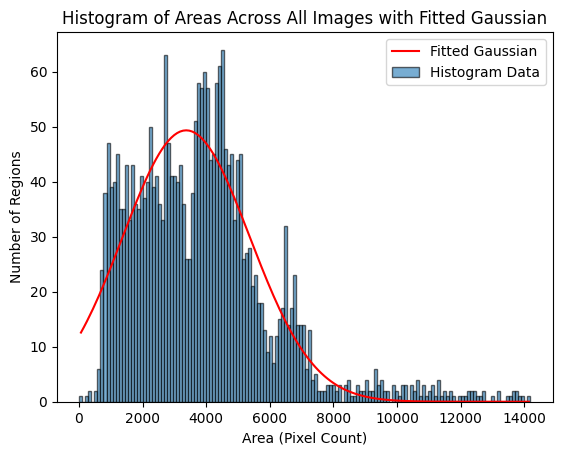

TypeError: cannot unpack non-iterable NoneType object

In [5]:
path='/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7'
name='test'
save_dir='test'
generate_CTC_datasets(path,name,save_dir)